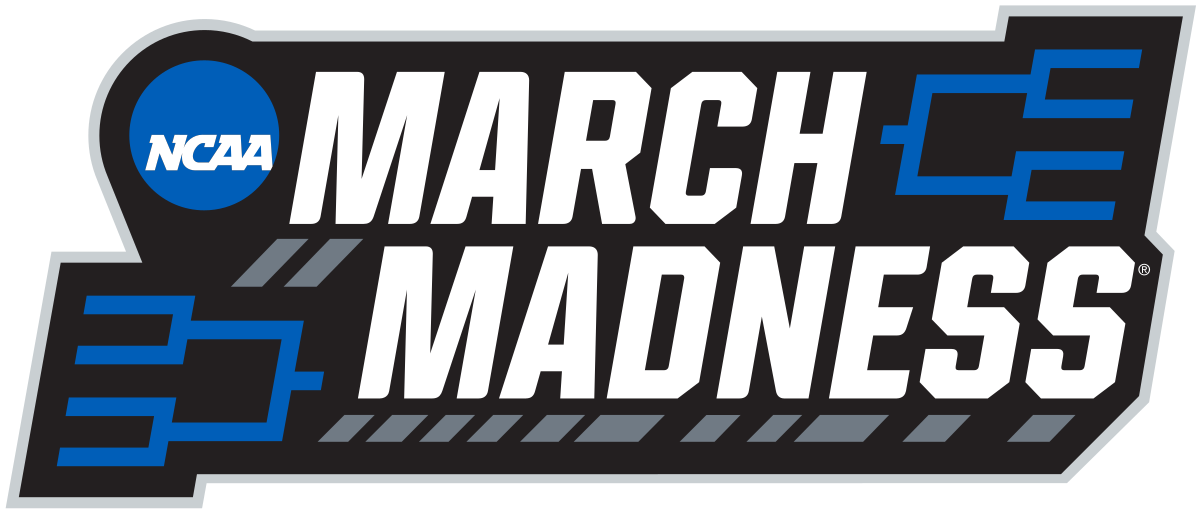

# Introduction:
Obviously, this will not have happened in 2020, but the scope of this project was to enter the 2020 March Madness Kaggle Competition that has since been cancelled.  
https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament

# Goal:
Create a classification algorithm to predict a March Madness Bracket using at least 10 predictor features.  Instead of submitting our picks for the 2020 tournament, this repo finishes with a feature classification model. 

This Notebook in particular is EDA work used to generate the dataset used in the models and data visualizations.


# EDA 
We have a lot of files to work with and can literally let the data take us in any real direction, but in the end, our goal is to determine what features have the heaviest influence on predicting who would win a basketball game given historical data about the team.

Altogether we're going to create 3 dataframes to help us in the modeling section, to be saved in the CreatedData folder.

- Aggregated Basic Statistics from Regular Season Games.
- Aggregated Advanced Statistics from Regular Season Games.
- Average Advanced Statistics of teams based on tourney results (How far they advanced)


In [1]:
# Import our libraries.

import pandas as pd
import numpy as np

carolinaBlue = 'deepskyblue'  # because d00k sucks

In [2]:
# load our data into pandas dataframes.

folder = "2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/"

DetailedResults = pd.read_csv(folder + "MNCAATourneyDetailedResults.csv")
teams = pd.read_csv(folder + "MTeams.csv")
historical_seeds = pd.read_csv(folder + "MNCAATourneySeeds.csv")
program_success = pd.read_csv("CreatedData/TourneyHistory.csv")
rounds = pd.read_csv(folder + "MNCAATourneySeedRoundSlots.csv")
RegSeason = pd.read_csv(folder + "MRegularSeasonDetailedResults.csv")
tourney_teams = pd.read_csv(folder + "MNCAATourneySeeds.csv")
Results = pd.read_csv(folder + "MNCAATourneyCompactResults.csv")

Basic Stats are provided:  
- Points per game 
- Assists per game
- Free Throw Attempts per game
- 3-point Field Goals per game
- Defensive Rebounds 
- Offensive Rebounds
- Steals
- Turnovers
- Blocks
- Personal Fouls

These 10 features are very basic and rudimentary and I chose them specifically to run through this model because I wanted a baseline to compare future models using advanced statistics to. 



In [3]:
RegSeason.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

Our Current data is organized by gameID and shows a winning and losing team.  In order to do our classifier correctly, we will need to reorganize our data by winners and losers and then combine them.




In [4]:
# we're pretty lucky with the data as it's actually quality data and 
# doesn't contain the bad apples we usually have to clean up.
# that said this problem is so open-ended so the Google folks must have felt a
# little responsibility to provide clean data.  Thanks Kaggle!

RegSeason.isna().sum()
RegSeason.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [5]:
# Since each line is essentially two separate teams stats, we need to seperate the df into a set of 
# only winners and only losers and then rename the columns so we can merge them all back in.   
# we add the win column to denote that statbox won the game or not.

winners = RegSeason.drop(['DayNum', 'LTeamID', 'LScore', 'WLoc','LFGM', 
                          'LFGA', 'LFGM3', 'LFGA3','LFTM', 'LFTA', 'LOR', 'LDR', 
                          'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'], axis=1)
winners['win'] = 1
losers = RegSeason.drop(['DayNum', 'WTeamID', 'WScore', 'WLoc',
                          'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
                          'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], axis=1)
losers['win'] = 0
print (winners.columns, losers.columns)

Index(['Season', 'WTeamID', 'WScore', 'NumOT', 'WFGM', 'WFGA', 'WFGM3',
       'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk',
       'WPF', 'win'],
      dtype='object') Index(['Season', 'LTeamID', 'LScore', 'NumOT', 'LFGM', 'LFGA', 'LFGM3',
       'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk',
       'LPF', 'win'],
      dtype='object')


In [6]:
# scrub scrub scrub, rub a dub dub.  I can't remember where 
# I saw this trick, and I wish I could give props to the person.

# Mass relabeling could have been awful without this (as we can see later with our advanced stats)

features_list = ['TeamID','Score','FGM','FGA','FGA3','FGM3','TO','FTM','FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']

In [7]:
# relabeling with a for loop

for factor in features_list:
    winners.rename(columns={'W'+factor: factor}, inplace=True)
    losers.rename(columns={'L'+factor: factor}, inplace=True)

In [8]:
# merge winners and losers keeping all season stats,  and then create a new index so we use it as a DF later.

RegSeason_all = winners.append(losers, sort=False)

In [9]:
# I need to index on something so created my own so I can some manipulation later.

RegSeason_all['RowID'] = np.arange(len(RegSeason_all))
RegSeason_all.set_index(['RowID'])
RegSeason_all.head()

,Season,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,win,RowID
0,2003,1104,68,0,27,58,3,14,11,18,14,24,13,23,7,1,22,1,0
1,2003,1272,70,0,26,62,8,20,10,19,15,28,16,13,4,4,18,1,1
2,2003,1266,73,0,24,58,8,18,17,29,17,26,15,10,5,2,25,1,2
3,2003,1296,56,0,18,38,3,9,17,31,6,19,11,12,14,2,18,1,3
4,2003,1400,77,0,30,61,6,14,11,13,17,22,12,14,4,4,20,1,4


In [10]:
# save this to .csv

RegSeason_all.to_csv('CreatedData/RegSeason_basics_all.csv', index=False)

# Slightly More Advance Stats

These baseball card (or basketball in this case) stats are fairly rudimentary and don't tell a good story in relationship to the game.  Points scored is very dependant on how many possessions occur during a game.   As # of possessions are roughly equal, it's who is more efficient with their possessions that normally win the game.   

A lot of basic calculations provided from kevin pelton of the NBA OKC Thunder: https://www.nba.com/thunder/news/stats101.html


- possession: .96 (FGattempt + TO + 0.44xFTA - Offensive Rebound)

Efficiency Metrics - all are Teaam-Based, and not individual player centric.

- True Shooting Percentatage: points scored / (2*(FGA + k*FTA)) #k is the ratio of 2 or 3 point attempts.  If all FTA are from 2pt fgs, it would be .5, while it would be .33 for all 3pfg fouls.  and 0 for all "and-1" attempts.   Wikipedia uses .44, so we'll go with that.

- Scoring Efficiency: average number of points scored per shot taken.  FGA + 0.44FTA / Possession

- Effective FG%:  adjusted fg% to account for 3 point fgs.   efg = (fg + .5x3pfg) / FGA

- Team Offensive Rebound Percent: oRB rate = OR / (OR + opp_DR)

- Team Defensive Rebound Percent: dRB rate = DR / (DR + opp_OR)
- Rebound Rate = Rebounds 

- Offensive Rating: points per 100 possessions:   Score/Possession

- Defensive Rating: Opponents Offensive rating

- Turnover Rate:  to_rate = TO / Poss

- Assist Ratio: (Assists)*100/[(Field Goal Attempts)+(Free Throw Attempts*0.44)+(Assists)+(Turnovers)]



In [11]:
# merge winners and losers and get their means

RegSeason_means = winners.append(losers, sort=False).groupby(['TeamID','Season']).mean().reset_index()

In [12]:
# Visualizing the data to make sure things look legit.

import matplotlib.pyplot as plt

plt.scatter(RegSeason_means.win.value_counts().index, RegSeason_means.win.value_counts().values)
plt.title('Win % Distribution')
plt.xlabel('% Wins in a Season')
plt.ylabel('Count of Win %')
plt.show()

<Figure size 640x480 with 1 Axes>

In [13]:
# Example: lets take a look at the 2003 season
mean2003 = RegSeason_means[RegSeason_means['Season']==2003]
mean2003.mean()

TeamID    1283.593272
Season    2003.000000
Score       69.680464
NumOT        0.061140
FGM         24.550438
FGA         56.093181
FGM3         6.254943
FGA3        18.051239
FTM         14.324645
FTA         20.621980
OR          11.728868
DR          23.101065
Ast         13.552585
TO          14.929370
Stl          7.055060
Blk          3.244834
PF          19.159224
win          0.494656
dtype: float64

In [14]:
RegSeason.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [15]:
# Calculating "advanced statistics" for each team, for all reg season games.
df = RegSeason.copy()
k = 0.44

In [16]:
# possessions for each team

df['WPossessions'] =  0.96 * (RegSeason['WFGA'] + k*RegSeason['WFTA'] + RegSeason['WTO'] - RegSeason['WOR'])
df['LPossessions'] =  0.96 * (RegSeason['LFGA'] + k*RegSeason['LFTA'] + RegSeason['LTO'] - RegSeason['LOR'])

In [17]:
# stats for winning teams

df['WShooting_Eff'] = RegSeason['WScore'] / (RegSeason['WFGA'] + k*RegSeason['WFTA'])
df['WEffectiveFGP'] = (RegSeason['WFGA'] + k*RegSeason['WFTA']) / df['WPossessions']
df['WFGP3'] = RegSeason['WFGM3'] / RegSeason['WFGA3']
df['WOff_Rating'] = 100 * RegSeason['WScore'] / df['WPossessions']
df['WDef_Rating'] = 100 * RegSeason['LScore'] / df['LPossessions']

df['WOff_RBP'] = RegSeason['WOR'] / (RegSeason['WOR'] + RegSeason['LDR'])
df['WDef_RBP'] = RegSeason['WDR'] / (RegSeason['LOR'] + RegSeason['WDR'])
df['WTot_RBP'] = (RegSeason['WOR'] + RegSeason['WDR'] ) \
               / (RegSeason['WOR'] + RegSeason['LDR'] + RegSeason['LOR'] + RegSeason['WDR'])

# winner Ratios 

df['WTO_Rate'] = RegSeason['WTO'] / df['WPossessions']
df['WFTP'] = RegSeason['WFTM'] / RegSeason['WFTA']
df['WAst_Ratio'] = 100 * RegSeason['WAst'] \
                / (RegSeason['WFGA'] + k*RegSeason['WFTA'] + RegSeason['WAst'] + RegSeason['WTO'])
df['WBlk_Ratio'] = 100 * RegSeason['WBlk'] / RegSeason['LFGA']
df['WStl_Ratio'] = 100 * RegSeason['WStl'] / df['LPossessions']

In [18]:
# stats for losing teams

df['LShooting_Eff'] = RegSeason['LScore'] / (RegSeason['LFGA'] + k*RegSeason['LFTA'])
df['LEffectiveFGP'] = (RegSeason['LFGA'] + k*RegSeason['LFTA']) / df['LPossessions']
df['LFGP3'] = RegSeason['LFGM3'] / RegSeason['LFGA3']
df['LOff_Rating'] = 100 * RegSeason['LScore'] / df['LPossessions']
df['LDef_Rating'] = 100 * RegSeason['WScore'] / df['WPossessions']

df['LOff_RBP'] = RegSeason['LOR'] / (RegSeason['LOR'] + RegSeason['WDR'])
df['LDef_RBP'] = RegSeason['LDR'] / (RegSeason['WOR'] + RegSeason['LDR'])
df['LTot_RBP'] = (RegSeason['LOR'] + RegSeason['LDR'] ) \
               / (RegSeason['LOR'] + RegSeason['WDR'] + RegSeason['WOR'] + RegSeason['LDR'])

# loser Ratios 

df['LTO_Rate'] = RegSeason['LTO'] / df['LPossessions']
df['LFTP'] = RegSeason['LFTM'] / RegSeason['LFTA']
df['LAst_Ratio'] = 100 * RegSeason['LAst'] \
                / (RegSeason['LFGA'] + k*RegSeason['LFTA'] + RegSeason['LAst'] + RegSeason['LTO'])
df['LBlk_Ratio'] = 100 * RegSeason['LBlk'] / RegSeason['WFGA']
df['LStl_Ratio'] = 100 * RegSeason['LStl'] / df['WPossessions']

In [19]:
# Rating margin

df['WRtg_Margin'] = df['WDef_Rating'] - df['LDef_Rating']
df['LRtg_Margin'] = df['LDef_Rating'] - df['WDef_Rating']

In [20]:
# getting the columns data so we can drop things accordingly

df.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'WPossessions', 'LPossessions', 'WShooting_Eff', 'WEffectiveFGP',
       'WFGP3', 'WOff_Rating', 'WDef_Rating', 'WOff_RBP', 'WDef_RBP',
       'WTot_RBP', 'WTO_Rate', 'WFTP', 'WAst_Ratio', 'WBlk_Ratio',
       'WStl_Ratio', 'LShooting_Eff', 'LEffectiveFGP', 'LFGP3', 'LOff_Rating',
       'LDef_Rating', 'LOff_RBP', 'LDef_RBP', 'LTot_RBP', 'LTO_Rate', 'LFTP',
       'LAst_Ratio', 'LBlk_Ratio', 'LStl_Ratio', 'WRtg_Margin', 'LRtg_Margin'],
      dtype='object')

In [21]:
# splitting into winners and losers again

winners = df.drop(['DayNum', 'LTeamID', 'LScore', 'WLoc', 'LFGM', 
                   'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 
                   'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
                   'LPossessions', 'LShooting_Eff', 'LEffectiveFGP',
                   'LOff_Rating', 'LDef_Rating', 'LRtg_Margin', 
                   'LOff_RBP', 'LDef_RBP', 'LTot_RBP', 
                   'LTO_Rate', 'LFTP', 'LAst_Ratio', 'LBlk_Ratio',
                   'LStl_Ratio', 'LFGP3'], axis=1)
winners['win'] = 1
losers = df.drop(['DayNum', 'WTeamID', 'WScore', 'WLoc','WFGM', 
                  'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 
                  'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 
                  'WPossessions', 'WShooting_Eff', 'WEffectiveFGP',
                  'WOff_Rating', 'WDef_Rating', 'WRtg_Margin', 
                  'WOff_RBP', 'WDef_RBP', 'WTot_RBP', 'WTot_RBP', 
                  'WTO_Rate', 'WFTP', 'WAst_Ratio', 'WBlk_Ratio', 
                  'WStl_Ratio', 'WFGP3'], axis=1)
losers['win'] = 0


In [22]:
# Mass relabeling again

features_list = ['TeamID', 'Score', 'NumOT', 'FGM', 'FGA', 'FGM3',
       'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk',
       'PF', 'Possessions', 'Shooting_Eff', 'EffectiveFGP', 'Off_Rating',
       'Def_Rating', 'Rtg_Margin', 'Off_RBP', 'Def_RBP', 'Tot-RBP',
       'Tot_RBP', 'TO_Rate', 'FTP', 'Ast_Ratio', 'Blk_Ratio',
       'Stl_Ratio', 'FGP3', 'win']

In [23]:
for factor in features_list:
    winners.rename(columns={'W'+factor: factor}, inplace=True)
    losers.rename(columns={'L'+factor: factor}, inplace=True)

In [24]:
# merge winners and losers 

RegSeason_advanced = winners.append(losers, sort=False)

In [25]:
# everything looks good!

RegSeason_advanced.head()

,Season,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,...,Off_RBP,Def_RBP,Tot_RBP,TO_Rate,FTP,Ast_Ratio,Blk_Ratio,Stl_Ratio,Rtg_Margin,win
0,2003,1104,68,0,27,58,3,14,11,18,...,0.388889,0.705882,0.542857,0.319786,0.611111,12.755102,1.886792,10.316450,-3.171024,1
1,2003,1272,70,0,26,62,8,20,10,19,...,0.375000,0.583333,0.488636,0.198093,0.526316,16.103060,5.970149,6.145526,-9.873656,1
2,2003,1266,73,0,24,58,8,18,17,29,...,0.435897,0.456140,0.447917,0.163373,0.586207,15.664160,2.739726,8.122791,-20.164293,1
3,2003,1296,56,0,18,38,3,9,17,31,...,0.230769,0.527778,0.403226,0.216863,0.548387,14.737406,4.081633,25.318287,-10.780415,1
4,2003,1400,77,0,30,61,6,14,11,13,...,0.531250,0.511628,0.520000,0.228866,0.846154,12.942192,6.451613,6.626378,-8.258015,1


In [26]:
# save this to .csv
RegSeason_advanced.to_csv('CreatedData/RegSeason_all.csv', index=False)

# Above Replacement Data

- what does the average NCAA D1 Team look like
- compared to average NCAA tournament teaam
- compared to average sweet 16
- final 4
- champ



In [27]:
# average NCAA D1 team

average_ncaa_team = RegSeason_means.mean()

In [28]:
# Taking a look at tour tourney  teams
Results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [29]:
# we need to convert our DayNum variable into the actual round it applies to.

def convertRound(DayNum):
    '''
    Convert DayNum to appropriate tournament round in a new column.   
    Play-In Games counted as 0, Round 1 as 1, etc.
    '''
    
    if (DayNum == 134) | (DayNum == 135):
        return 68
    elif (DayNum == 136) | (DayNum == 137):
        return 64
    elif (DayNum == 138) | (DayNum == 139):
        return 32
    elif (DayNum == 143) | (DayNum == 144):
        return 16
    elif (DayNum == 145) | (DayNum == 146):
        return 8
    elif (DayNum == 152):
        return 4
    else:
        #only left over daynum should be 154 at this point.
        return 2
    

In [30]:
# get dummies for each team that played in each round.

Results['Round'] = Results.DayNum.apply(convertRound)
Results = pd.concat([Results, pd.get_dummies(Results['Round'], prefix='Round')], axis=1)


In [31]:
Results = Results.drop(columns=['Round'])

In [32]:
# split them into Winners and Losers again to seperate the data out.

LResults = Results.drop(columns = ['DayNum', 'WTeamID', 'WScore', 'LScore', 'WLoc','NumOT'])
LResults.rename(columns={'LTeamID': 'TeamID'}, inplace=True)
WResults = Results.drop(columns = ['DayNum', 'LTeamID', 'WScore', 'LScore', 'WLoc','NumOT'])
WResults.rename(columns={'WTeamID': 'TeamID'}, inplace=True)

In [33]:
# bring them back together as single df and group by Season and TeamID

temp_df = WResults.append(LResults, sort=False)
grouped_df = temp_df.groupby(['Season', 'TeamID']).sum().reset_index() 

Now we have how far each team went, we can use it to slice our reg season data to show how far certain teams made it in the "big dance."

lets merge the tourney resutls back to our regular season data.

In [34]:
# Bring this back to our bigger data set.

df = pd.merge(RegSeason_advanced, grouped_df, left_on=['Season', 'TeamID'], right_on = ['Season', 'TeamID'])

In [35]:
# create df for our mean teams by rounds

average_team_df = pd.DataFrame(df.mean(), columns=['All_Teams'] ).transpose().rename_axis('Round', axis=1)
rounds = ['Round_68', 'Round_64', 'Round_32', 'Round_16', 'Round_8', 'Round_4', 'Round_2']

In [36]:
# append for each round

for r in rounds:
    temp_df = pd.DataFrame(df[df[r]==1].mean(), columns=[r] ).transpose().rename_axis('Round', axis=1)
    average_team_df = average_team_df.append(temp_df)

In [37]:
average_team_df = average_team_df.drop(columns=['Season', 'NumOT', 'TeamID', 'win', 'Round_2',
       'Round_4', 'Round_8', 'Round_16', 'Round_32', 'Round_64', 'Round_68'])

In [38]:
# review looks good!

average_team_df.columns

Index(['Score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast',
       'TO', 'Stl', 'Blk', 'PF', 'Possessions', 'Shooting_Eff', 'EffectiveFGP',
       'FGP3', 'Off_Rating', 'Def_Rating', 'Off_RBP', 'Def_RBP', 'Tot_RBP',
       'TO_Rate', 'FTP', 'Ast_Ratio', 'Blk_Ratio', 'Stl_Ratio', 'Rtg_Margin'],
      dtype='object', name='Round')

In [39]:
# lets bin the unecessary stats

average_team_advanced_stats = average_team_df.drop(columns = ['Score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast',
       'TO', 'Stl', 'Blk'])

In [40]:
#resulting DF

average_team_advanced_stats

Round,PF,Possessions,Shooting_Eff,EffectiveFGP,FGP3,Off_Rating,Def_Rating,Off_RBP,Def_RBP,Tot_RBP,TO_Rate,FTP,Ast_Ratio,Blk_Ratio,Stl_Ratio,Rtg_Margin
All_Teams,17.783260,64.556262,1.124076,1.022007,0.360476,114.402910,102.039962,0.334531,0.696799,0.520689,0.197075,0.704782,15.353839,6.910542,10.615307,-12.362949
Round_68,18.486913,64.879437,1.093461,1.012441,0.348834,110.311668,105.180565,0.313124,0.693530,0.504945,0.198453,0.701460,14.418198,5.942481,10.323127,-5.131103
Round_64,17.742675,64.517406,1.125196,1.022353,0.360866,114.552113,101.915949,0.335307,0.696954,0.521291,0.197020,0.705091,15.388525,6.964516,10.631815,-12.636164
Round_32,17.511877,64.472933,1.130305,1.031282,0.362421,116.078681,100.736712,0.342990,0.697591,0.525779,0.192448,0.706091,15.653942,7.378901,10.786571,-15.341969
Round_16,17.309850,64.591663,1.137541,1.034654,0.364992,117.207395,100.124393,0.346918,0.697652,0.528367,0.190438,0.707307,15.773639,7.602842,10.952978,-17.083002
Round_8,17.126927,64.798050,1.142606,1.037193,0.364819,118.023100,99.278530,0.353220,0.699737,0.533177,0.190796,0.705560,15.869076,7.885526,11.072371,-18.744569
Round_4,16.915047,64.518403,1.145616,1.037178,0.364105,118.303640,98.704805,0.355688,0.700383,0.535460,0.191566,0.709968,15.979847,7.989786,11.079773,-19.598835
Round_2,16.749329,64.863754,1.154005,1.039646,0.365804,119.505534,98.035736,0.353571,0.704361,0.537582,0.186585,0.713843,16.080374,8.056451,10.997546,-21.469798


In [41]:
# save this to .csv
average_team_advanced_stats.to_csv('CreatedData/Advanced_stats_by_round.csv', index=False)